# CNNs comparisons using trasfer learning for image classification

We compare the performance of ResNet18 under the different cases:

- no transfer learning,
- using ImageNet-trained model as initial weights and continuing full training from there,
- using ImageNet-trained model as initial weights, freezing all layers but input convolutional layer and the classification linear layer.

We work with FashionMNIST which contains grayscale images. Hence we had to modify the original ResNet18 to take a 2D image as opposed to an RGB image. This means that we are not using the trained weights of the original model for the input layer, even in the presence of transfer learning.


### Results:

* Achieved mean test accuracy = 92%.

* Best performing case was training the full network but using transferr learning. This case might win over freezing the middle layers since we are working with grayscale images as opposed to RGB images. So the full training might move the weights to compensate for this difference.

* For comparison, at the end I fully trained a ResNet34 using transfer learning. It has about 2x the number of weights. It achieved a slightly lower loss. Probably if we train all cases for longer, this model would be the best.

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.models import resnet18, resnet34
from torch.nn.modules.batchnorm import BatchNorm2d
from torchvision.transforms import (Compose,
                                    PILToTensor,
                                    ToTensor,
                                    RandomAffine,
                                    Normalize,
                                    RandomResizedCrop)
from torchvision.utils import make_grid
from torchvision.transforms.functional import InterpolationMode

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from collections import OrderedDict

from IPython.display import clear_output

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

MODELS_PATH = '/content/drive/MyDrive/22_vision/10_models/'

# Data

Load FashionMNIST

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


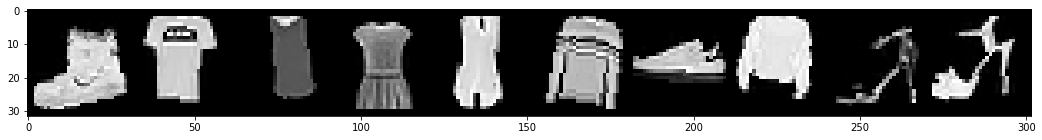

In [3]:
# transforms
train_transforms = Compose([
                            ToTensor(),
                            RandomAffine(15, translate=(0.1, 0.1), scale = (0.9, 1.1))
                            ])

test_transforms = Compose([ToTensor()])

# datasets
fashion_train_ds = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/data', 
                                  train = True, 
                                  download=False,
                                  transform=train_transforms
                                  )


fashion_test_ds = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/data', 
                                  train = False, 
                                  download=False,
                                  transform=test_transforms
                                  )
# show augmented examples
demo_loader = DataLoader(fashion_train_ds, batch_size=10)
images, _ = next(iter(demo_loader))

plt.figure(figsize=(18,12))
plt.imshow(torch.permute(make_grid(images, nrow=10), (1,2,0)))
plt.show()

# Architecture

In [5]:
class ResNet18(nn.Module):
    """
    ResNet18 backbone.

    Can be used pretrained or not using boolean flag.

    11175370 params.
    """
    def __init__(self, pretrained = False):
        super().__init__()

        # instatiate the resnet
        self.resnet = resnet18(pretrained = pretrained)
        # modify head to take grayscale immage
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # modify the output size of the original network
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet(x).squeeze()
        return x

In [9]:
torch.manual_seed(0)
resnet18_model_NotPretrain = ResNet18(pretrained = False).to(device)
print('number of params', sum([p.numel() for p in resnet18_model_NotPretrain.parameters() if p.requires_grad]))

img = fashion_train_ds[0][0].unsqueeze(0).cuda()

resnet18_model_NotPretrain.eval()
resnet18_model_NotPretrain(img).size()

number of params 11175370


torch.Size([10])

# Run manager

In [11]:
class RunManager():
    def __init__(self):

        # tracking every epoch count, loss, accuracy, time
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.epoch_start_time = None

        # variables to test data
        self.epoch_loss_test = 0
        self.epoch_num_correct_test = 0

        # tracking every run count, run data, hyper-params used, time
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None

        #  to store run scores
        self.df = None

    # record the count, hyper-param, model, loader of each run
    # record sample images and network graph to TensorBoard  
    def begin_run(self, network, loader, val_loader):

        self.run_start_time = time.time()
        self.run_count += 1
        self.network = network
        self.loader = loader
        self.val_loader = val_loader
  
    def begin_epoch(self):
        self.epoch_start_time = time.time()

        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_epoch_loss = 0
        self.val_epoch_num_correct = 0

    def end_epoch(self):
        # calculate epoch duration and run duration(accumulate)
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time

        # record epoch loss and accuracy
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)

        val_loss = self.val_epoch_loss / len(self.val_loader.dataset)
        val_accuracy = self.val_epoch_num_correct / len(self.val_loader.dataset)
        
        # Write into 'results' (OrderedDict) for all run related data
        results = OrderedDict()
        results["run"] = self.run_count
        results["epoch"] = self.epoch_count
        results["loss"] = loss
        results["val_loss"] = val_loss
        results["accuracy"] = accuracy
        results["val_accuracy"] = val_accuracy
        results["epoch duration"] = epoch_duration
        results["run duration"] = run_duration

        # Record hyper-params into 'results'
        # for k,v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

        # display epoch information and show progress
        clear_output(wait=True)
        display(df)

        self.df = df

    # accumulate test loss of batch into entire test epoch loss
    def track_loss(self, loss, training = True):
        # multiply batch size so variety of batch sizes can be compared
        if training:
            self.epoch_loss += loss.item() * self.loader.batch_size
        else:
            self.val_epoch_loss += loss.item() * self.val_loader.batch_size

    # accumulate number of corrects of batch into entire epoch num_correct
    def track_num_correct(self, preds, labels, training = True):
        if training:
            self.epoch_num_correct += self._get_num_correct(preds, labels)
        else:
            self.val_epoch_num_correct  += self._get_num_correct(preds, labels)

    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

# ResNet18 - no transfer learning

In [13]:
BATCH_SIZE = 100
LR = 0.001
NUM_EPOCHS = 30

# dataloaders
train_loader = DataLoader(fashion_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(fashion_test_ds, batch_size=BATCH_SIZE, shuffle=False)

,run,epoch,loss,val_loss,accuracy,val_accuracy,epoch duration,run duration
0,1,1,0.730475,0.546185,0.717333,0.7998,42.333625,42.333768
1,1,2,0.504228,0.417770,0.809517,0.8438,41.889378,84.242105
2,1,3,0.455203,0.382810,0.826767,0.8573,40.745808,125.000805
3,1,4,0.416846,0.345996,0.840767,0.8728,39.355322,164.368669
4,1,5,0.394771,0.351126,0.850883,0.8735,40.076331,204.455813
5,1,6,0.378878,0.322574,0.856467,0.8804,40.014617,244.484250
6,1,7,0.363699,0.322956,0.863167,0.8778,40.990373,285.487940
7,1,8,0.353130,0.313376,0.865717,0.8831,40.734581,326.235884
8,1,9,0.341382,0.328258,0.870367,0.8786,40.214317,366.464159
9,1,10,0.337493,0.291895,0.873267,0.8922,39.385617,405.863776


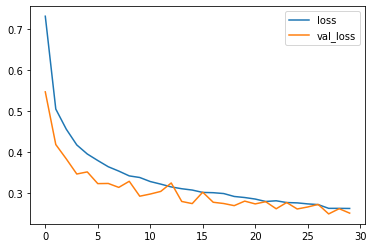

In [10]:
optimizer = Adam(resnet18_model_NotPretrain.parameters(), lr = LR)

m = RunManager()

m.begin_run(resnet18_model_NotPretrain, train_loader, test_loader)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    m.begin_epoch()
    for batch in train_loader:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = resnet18_model_NotPretrain(images)
        loss = F.cross_entropy(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(out, labels)

    with torch.no_grad():
        epoch_loss_val = []
        for batch in test_loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            out = resnet18_model_NotPretrain(images)

            loss = F.cross_entropy(out, labels)
            m.track_loss(loss, training = False)
            m.track_num_correct(out, labels, training = False)

    m.end_epoch()

# plot curves
m.df.plot(y=['loss', 'val_loss'])
plt.show()

In [11]:
torch.save(resnet18_model_NotPretrain.state_dict(), os.path.join(MODELS_PATH, 'resnet18_not_pretrained_FashionMNIST.pt'))

### Metrics

In [7]:
os.path.join(MODELS_PATH, 'resnet18_not_pretrained_FashionMNIST.pt')

'/content/drive/MyDrive/22_vision/10_models/resnet18_not_pretrained_FashionMNIST.pt'

In [10]:
device

'cpu'

In [11]:
from sklearn.metrics import classification_report, accuracy_score


resnet18_model_NotPretrain = ResNet18(False).to(device)
resnet18_model_NotPretrain.load_state_dict(torch.load(os.path.join(MODELS_PATH, 'resnet18_not_pretrained_FashionMNIST.pt'), map_location='cpu'))


# collect predictions and ground truths
results = []
ground_truth = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet18_model_NotPretrain(images)
        outputs = torch.argmax(outputs,1)
        results += outputs.tolist()
        ground_truth += labels.tolist()

<All keys matched successfully>

In [55]:
print(f"Accuracy on the test set = {accuracy_score(ground_truth, results) : .2f}")

print(classification_report(ground_truth, results))

Accuracy on the test set =  0.92
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.90      0.82      0.86      1000
           3       0.88      0.96      0.92      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.79      0.73      0.76      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



# ResNet18 - pretrained. Train all.

Starting with pre-trained and training the whole network.

In [12]:
torch.manual_seed(0)
resnet18_model_Pretrain = ResNet18(pretrained = True).to(device)
optimizer = Adam(resnet18_model_Pretrain.parameters(), lr = LR)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
m = RunManager()

m.begin_run(resnet18_model_Pretrain, train_loader, test_loader)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    m.begin_epoch()
    for batch in train_loader:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = resnet18_model_Pretrain(images)
        loss = F.cross_entropy(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(out, labels)

    with torch.no_grad():
        epoch_loss_val = []
        for batch in test_loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            out = resnet18_model_Pretrain(images)

            loss = F.cross_entropy(out, labels)
            m.track_loss(loss, training = False)
            m.track_num_correct(out, labels, training = False)

    m.end_epoch()

,run,epoch,loss,val_loss,accuracy,val_accuracy,epoch duration,run duration
0,1,1,0.637469,0.448232,0.761517,0.8362,41.918350,41.918781
1,1,2,0.458487,0.380023,0.829350,0.8567,38.974738,80.906234
2,1,3,0.412357,0.352924,0.845550,0.8677,38.791212,119.707484
3,1,4,0.378416,0.330285,0.857500,0.8797,38.706050,158.424788
4,1,5,0.357394,0.326671,0.867850,0.8758,39.394725,197.831615
5,1,6,0.341757,0.302387,0.873817,0.8890,38.924614,236.768159
6,1,7,0.333169,0.300373,0.876400,0.8921,39.551874,276.333079
7,1,8,0.318914,0.307156,0.881000,0.8798,40.039695,316.384130
8,1,9,0.311509,0.322540,0.883533,0.8856,40.897442,357.293096
9,1,10,0.309277,0.272417,0.884633,0.8987,39.348319,396.653319


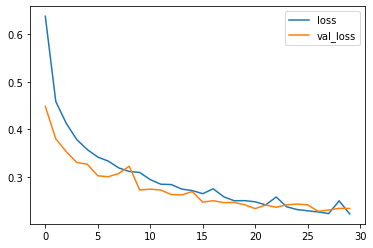

In [14]:
m.df.plot(y=['loss', 'val_loss'])
plt.show()

In [15]:
torch.save(resnet18_model_Pretrain.state_dict(), os.path.join(MODELS_PATH, 'resnet18_not_pretrained_FashionMNIST.pt'))

# ResNet18 - pretrained. Train input layer and classification layer

Starting with pre-trained and training last layer as the classifier.

In [23]:
torch.manual_seed(0)
resnet18_model_freeze = ResNet18(pretrained = True).to(device)

# freeze all parameters ahead of the classifier
for p in resnet18_model_freeze.resnet.parameters():
    p.requires_grad = False

for p in resnet18_model_freeze.resnet.fc.parameters():
    p.requires_grad = True

for p in resnet18_model_freeze.resnet.conv1.parameters():
    p.requires_grad = True

print(f"Number of free params = {sum([p.numel() for p in resnet18_model_freeze.resnet.parameters() if p.requires_grad])}")

Number of free params = 8266


In [24]:
optimizer = Adam(resnet18_model_freeze.parameters(), lr = LR)

,run,epoch,loss,val_loss,accuracy,val_accuracy,epoch duration,run duration
0,1,1,1.223572,0.897922,0.565450,0.6761,47.700197,47.700345
1,1,2,0.951266,0.819044,0.655417,0.7077,45.086298,92.800526
2,1,3,0.898796,0.813007,0.674450,0.7074,44.196064,137.009528
3,1,4,0.870466,0.765725,0.679183,0.7217,43.906698,180.927989
4,1,5,0.853231,0.764863,0.688417,0.7269,43.597788,224.536667
5,1,6,0.840463,0.758044,0.691583,0.7305,43.713949,268.261909
6,1,7,0.834337,0.752071,0.697083,0.7315,44.050941,312.326271
7,1,8,0.827332,0.755851,0.698567,0.7241,43.769008,356.106445
8,1,9,0.818715,0.738444,0.701683,0.7360,43.755173,399.876051
9,1,10,0.804191,0.726868,0.705367,0.7418,43.552178,443.440477


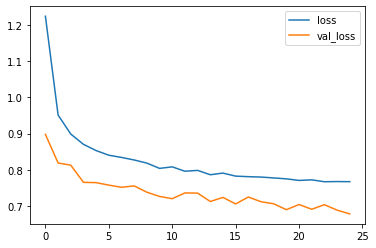

In [25]:
m = RunManager()

m.begin_run(resnet18_model_freeze, train_loader, test_loader)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    m.begin_epoch()
    for batch in train_loader:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = resnet18_model_freeze(images)
        loss = F.cross_entropy(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(out, labels)

    with torch.no_grad():
        epoch_loss_val = []
        for batch in test_loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            out = resnet18_model_freeze(images)

            loss = F.cross_entropy(out, labels)
            m.track_loss(loss, training = False)
            m.track_num_correct(out, labels, training = False)

    m.end_epoch()


m.df.plot(y=['loss', 'val_loss'])
plt.show()

# Creating RGB channels

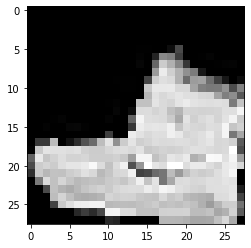

size of image = torch.Size([3, 28, 28])



In [5]:
class Stack(nn.Module):
    """Creates trivial RGB image by stacking a
    grayscale image"""

    def __init__(self):

        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return torch.stack((x, x, x)).squeeze()


# hyperparams
BATCH_SIZE = 100
LR = 0.001
NUM_EPOCHS = 25

# transforms
train_transforms = Compose([
                            ToTensor(),
                            RandomAffine(15, translate=(0.1, 0.1), scale = (0.9, 1.1)),
                            Stack()
                            ])

test_transforms = Compose([ToTensor(), Stack()])

# datasets
fashion_train_ds = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/data', 
                                  train = True, 
                                  download=False,
                                  transform=train_transforms
                                  )


fashion_test_ds = torchvision.datasets.FashionMNIST(root='/content/drive/MyDrive/data', 
                                  train = False, 
                                  download=False,
                                  transform=test_transforms
                                  )

# dataloaders
train_loader = DataLoader(fashion_train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(fashion_test_ds, batch_size=BATCH_SIZE, shuffle=False)


# show augmented example
plt.imshow(torch.permute(fashion_train_ds[0][0], (1,2,0)))
plt.show()

print(f'size of image = {fashion_train_ds[0][0].size()}\n')

In [6]:
class ResNet18_3C(nn.Module):
    """
    ResNet18 backbone taking RGB images.

    Can be used pretrained or not using boolean flag.

    11_175_370 params.
    """
    def __init__(self, pretrained = False):
        super().__init__()

        # instatiate the resnet
        self.resnet = resnet18(pretrained = pretrained)
        # modify the output size of the original network
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet(x).squeeze()
        return x

In [7]:
torch.manual_seed(0)
resnet18_model_freeze = ResNet18_3C(pretrained = True).to(device)

# freeze all parameters ahead of the classifier
for p in resnet18_model_freeze.resnet.parameters():
    p.requires_grad = False

for p in resnet18_model_freeze.resnet.fc.parameters():
    p.requires_grad = True

print(f"Number of free params = {sum([p.numel() for p in resnet18_model_freeze.parameters() if p.requires_grad])}")

Number of free params = 5130


In [8]:
optimizer = Adam(resnet18_model_freeze.parameters(), lr = LR)

,run,epoch,loss,val_loss,accuracy,val_accuracy,epoch duration,run duration
0,1,1,1.279777,1.008227,0.560067,0.6468,38.714853,38.715111
1,1,2,1.086044,0.983159,0.618383,0.6547,37.537952,76.268640
2,1,3,1.067704,0.954537,0.624050,0.6659,37.945207,114.227457
3,1,4,1.053886,0.939024,0.628067,0.6693,37.906381,152.146773
4,1,5,1.043766,0.940487,0.632817,0.6664,37.706063,189.864783
5,1,6,1.036507,0.923626,0.633083,0.6754,38.465142,228.344397
6,1,7,1.040685,0.938906,0.630650,0.6687,37.676389,266.033315
7,1,8,1.035060,0.926315,0.634667,0.6747,37.944655,303.991397
8,1,9,1.043488,0.931829,0.629417,0.6710,37.414145,341.417853
9,1,10,1.032801,0.919402,0.634250,0.6738,37.496588,378.927213


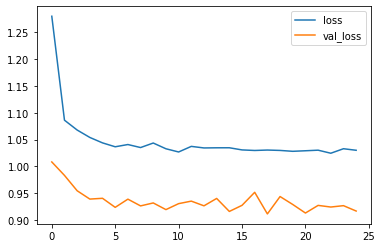

In [9]:
m = RunManager()

m.begin_run(resnet18_model_freeze, train_loader, test_loader)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    m.begin_epoch()
    for batch in train_loader:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = resnet18_model_freeze(images)
        loss = F.cross_entropy(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(out, labels)

    with torch.no_grad():
        epoch_loss_val = []
        for batch in test_loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            out = resnet18_model_freeze(images)

            loss = F.cross_entropy(out, labels)
            m.track_loss(loss, training = False)
            m.track_num_correct(out, labels, training = False)

    m.end_epoch()


m.df.plot(y=['loss', 'val_loss'])
plt.show()

# Bigger net

For comparison we use a ResNet34 here, again modifying the input layer to take in grayscale image. We will train starting with the ImageNet weights.

In [14]:
from torchvision.models import resnet34


class ResNet34(nn.Module):
    """
    ResNet34 backbone.

    Can be used pretrained or not using boolean flag.

    21283530 params.
    """
    def __init__(self, pretrained = False):
        super().__init__()

        # instatiate the resnet
        self.resnet = resnet34(pretrained = pretrained)
        # modify head to take grayscale immage
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # modify the output size of the original network
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 10)

    def forward(self, x):
        x = self.resnet(x).squeeze()
        return x



torch.manual_seed(0)
resnet34_model_NotPretrain = ResNet34(pretrained = True).to(device)
print('number of params', sum([p.numel() for p in resnet34_model_NotPretrain.parameters() if p.requires_grad]))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

number of params 21283530


,run,epoch,loss,val_loss,accuracy,val_accuracy,epoch duration,run duration
0,1,1,0.634605,0.466782,0.762067,0.8274,51.228671,51.228835
1,1,2,0.455832,0.374338,0.829700,0.8585,50.927542,102.168083
2,1,3,0.412974,0.371197,0.846367,0.8626,50.822411,153.000642
3,1,4,0.376928,0.322742,0.857767,0.8784,50.862720,203.874537
4,1,5,0.351442,0.311893,0.867667,0.8838,51.207752,255.096299
5,1,6,0.336699,0.313689,0.873683,0.8841,50.822538,305.931437
6,1,7,0.334827,0.308535,0.873867,0.8843,51.421966,357.366485
7,1,8,0.341382,0.283160,0.872250,0.8935,50.846703,408.224959
8,1,9,0.312111,0.282614,0.882550,0.8965,51.026150,459.264163
9,1,10,0.299772,0.275537,0.888233,0.8980,50.735805,510.012664


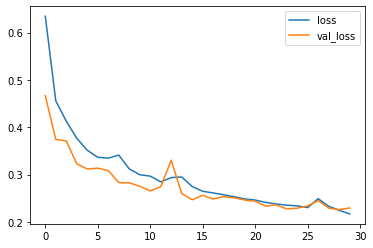

In [15]:
optimizer = Adam(resnet34_model_NotPretrain.parameters(), lr = LR)

m = RunManager()

m.begin_run(resnet34_model_NotPretrain, train_loader, test_loader)

for epoch in range(NUM_EPOCHS):
    epoch_loss = []
    m.begin_epoch()
    for batch in train_loader:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        out = resnet34_model_NotPretrain(images)
        loss = F.cross_entropy(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(out, labels)

    with torch.no_grad():
        epoch_loss_val = []
        for batch in test_loader:

            images = batch[0].to(device)
            labels = batch[1].to(device)
            out = resnet34_model_NotPretrain(images)

            loss = F.cross_entropy(out, labels)
            m.track_loss(loss, training = False)
            m.track_num_correct(out, labels, training = False)

    m.end_epoch()

# plot curves
m.df.plot(y=['loss', 'val_loss'])
plt.show()